In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [0]:
#Reading data
df = pd.read_csv('time_series_covid_19_confirmed.csv').groupby('Country/Region').sum().iloc[:, :-3]

In [0]:
#Using data for those countries that have at least 1000 cases
df_q3 = df[df['5/27/20']>=1000]

#Computing the ratio of cases to amount of days 
difference = list()
column_len = len(df_q3.columns[2:].values.tolist())
for i in range(column_len):
  for j, index in enumerate(df_q3.index.values.tolist()):
    if len(difference) <= j:
      difference.append([[], index])
    difference[j][0].append(df_q3.loc[index, df_q3.columns[2:].values.tolist()[i]]/(i+1))

difference.sort()

In [66]:
#Finding difference between ratios of different countries as compared to Pakistan
abs_diff = list()
for i, index in enumerate(difference):
  for j in range(len(index[0])):
    if len(abs_diff) <= i:
      abs_diff.append([0, index[1]])
    abs_diff[i][0] += abs(difference[74][0][j]-index[0][j])
abs_diff.sort()
abs_diff[1:10]

[[1721.9454950712793, 'Chile'],
 [2262.0306862289153, 'Mexico'],
 [2838.6314476331977, 'Qatar'],
 [3202.0318680393098, 'Ecuador'],
 [3395.7803689645557, 'Singapore'],
 [3517.195651730621, 'Saudi Arabia'],
 [3528.2307704979007, 'Belarus'],
 [4351.3766380793295, 'Sweden'],
 [4368.098669863031, 'United Arab Emirates']]

In [0]:
#Using countries that match the best
trend_countries = df[(df.index=='Saudi Arabia')|(df.index=='Belarus')|(df.index=='Chile')|(df.index=='Qatar')|(df.index=='Pakistan')|(df.index=='Mexico')]

Text(0.5, 1.0, 'Countries with trends similar to Pakistan - COVID-19')

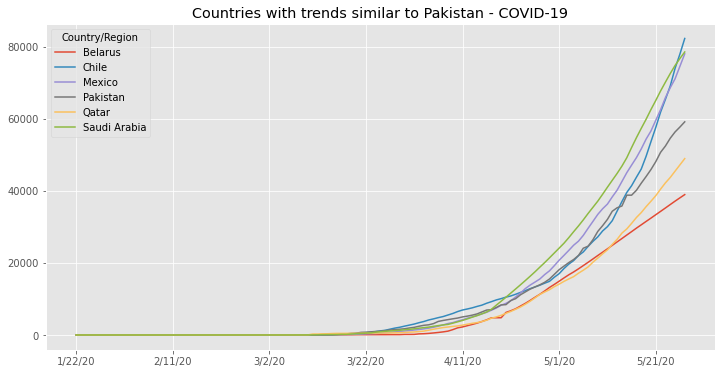

In [68]:
#Verifying trend through graph
trend_countries.iloc[:, 2:].T.plot(figsize=(12,6))
plt.title("Countries with trends similar to Pakistan - COVID-19")

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from dateutil import parser
import datetime
import warnings

In [0]:
#Making a list of all dates for the moving window
datelist = list()
date = parser.parse("02/08/20")
datelist.append(date.strftime("%m/%d/%Y"))
for i in range (140):
  date += datetime.timedelta(days=1)
  datelist.append(date.strftime("%m/%d/%Y"))

In [0]:
#Retrieving data for similar countries by trend of COVID19 for LSTM
pak_series = df_q3[df_q3.index=='Pakistan'].iloc[:,2:].T.values
belarus_series = df_q3[df_q3.index=='Belarus'].iloc[:,2:].T.values
chile_series = df_q3[df_q3.index=='Chile'].iloc[:,2:].T.values
mexico_series = df_q3[df_q3.index=='Mexico'].iloc[:,2:].T.values
qatar_series = df_q3[df_q3.index=='Qatar'].iloc[:,2:].T.values
saudi_series = df_q3[df_q3.index=='Saudi Arabia'].iloc[:,2:].T.values

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [0]:
def get_dailydata(data):
  out_data = list()
  out_data.append(data[0].tolist())
  for i in range(1, len(data)):
    out_data.append(data[i] - data[i-1])
  return out_data

In [0]:
pak_series_daily = get_dailydata(pak_series)
belarus_series_daily = get_dailydata(belarus_series)
chile_series_daily = get_dailydata(chile_series)
mexico_series_daily = get_dailydata(mexico_series)
qatar_series_daily = get_dailydata(qatar_series)
saudi_series_daily = get_dailydata(saudi_series)

In [0]:
def seq_gen(data, length):
    x = []
    y = []

    for i in range(len(data)-length-1):
        x_data = data[i:(i+length)]
        y_data = data[i+length]
        x.append(x_data)
        y.append(y_data)

    return np.array(x),np.array(y)

def process_data(train_set):
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_set)

  x, y = seq_gen(train_data, 15)
  train_size = int(len(y[0:109]))
  test_size = len(y) - train_size

  X = Variable(torch.Tensor(np.array(x)))
  Y = Variable(torch.Tensor(np.array(y)))

  train_X = Variable(torch.Tensor(np.array(x[0:train_size])))
  train_Y = Variable(torch.Tensor(np.array(y[0:train_size])))

  test_X = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
  test_Y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

  return X, Y, train_X, train_Y, test_X, test_Y, scaler, train_set

In [0]:
pak_s_processed = process_data(pak_series_daily)
bel_s_processed = process_data(belarus_series_daily)
chi_s_processed = process_data(chile_series_daily)
mex_s_processed = process_data(mexico_series_daily)
qat_s_processed = process_data(qatar_series_daily)
sau_s_processed = process_data(saudi_series_daily)

In [0]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 15
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [0]:
def train_model_LSTM(train_X, train_Y):
  num_epochs = 1500
  learning_rate = 0.006
  hidden_size = 200

  LSTM_model = LSTM(1, 1, hidden_size, 1)

  loss_typ = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      preds = LSTM_model(train_X)
      optimizer.zero_grad()
      
      # obtain the loss function
      loss = loss_typ(preds, train_Y)
      
      loss.backward()
      
      optimizer.step()
      #if epoch % 100 == 0:
       #print("Epoch No:", epoch, ", Loss:", loss.item())
  return LSTM_model


In [0]:
lstm_pak = train_model_LSTM(pak_s_processed[2], pak_s_processed[3])
lstm_bel = train_model_LSTM(bel_s_processed[2], bel_s_processed[3])
lstm_chi = train_model_LSTM(chi_s_processed[2], chi_s_processed[3])
lstm_mex = train_model_LSTM(mex_s_processed[2], mex_s_processed[3])
lstm_qat = train_model_LSTM(qat_s_processed[2], qat_s_processed[3])
lstm_sau = train_model_LSTM(sau_s_processed[2], sau_s_processed[3])

In [0]:
def forecaster(model, data_predicted, timesteps):
  preds = data_predicted.tolist()
  future_preds = list()
  for i in range(timesteps):
    np = process_data(preds)
    new_predict = model(np[0])
    preds.append(np[6].inverse_transform(new_predict[-1].detach().numpy().reshape(-1, 1)))
    future_preds.append(preds[-1][0].tolist())
  return future_preds

In [0]:
def evaluatemodel(series, model):
  model.eval()
  train_predict = model(series[0])

  data_predict = series[6].inverse_transform(train_predict.data.numpy())
  og_data = series[6].inverse_transform(series[1].data.numpy())

  np = process_data(data_predict)
  new_predict = model(np[0])
  
  return og_data, data_predict, forecaster(model, data_predict, 30)

In [0]:
evm_pak = evaluatemodel(pak_s_processed, lstm_pak)
evm_bel = evaluatemodel(bel_s_processed, lstm_bel)
evm_chi = evaluatemodel(chi_s_processed, lstm_chi)
evm_mex = evaluatemodel(mex_s_processed, lstm_mex)
evm_qat = evaluatemodel(qat_s_processed, lstm_qat)
evm_sau = evaluatemodel(sau_s_processed, lstm_sau)


In [0]:
def post_processing(all_data, country_name):
  df_og = pd.DataFrame(all_data[0]).T
  df_og.columns = datelist[:111]
  df_pred = pd.DataFrame(all_data[1]).T
  df_pred.columns = datelist[:111]
  df_forecast = pd.DataFrame(all_data[2]).T
  df_forecast.columns = datelist[111:]

  frames = [df_og, df_pred, df_forecast]
  result = pd.concat(frames)
  result.head(10)
  result.index = ['Original Series', 'Predicted Series', 'Forecasted series']
  result.T.plot(figsize=((12,6)))
  plt.axvline(x=92, linewidth=1, color='gray', label='Test data starts', linestyle='--')
  plt.xticks(rotation=45)
  plt.gca().set_ylim(bottom=0)
  plt.title("Daily cases predictor of COVID-19 for Pakistan using data of " + country_name)

  

# Predicting with the model of Chile: 

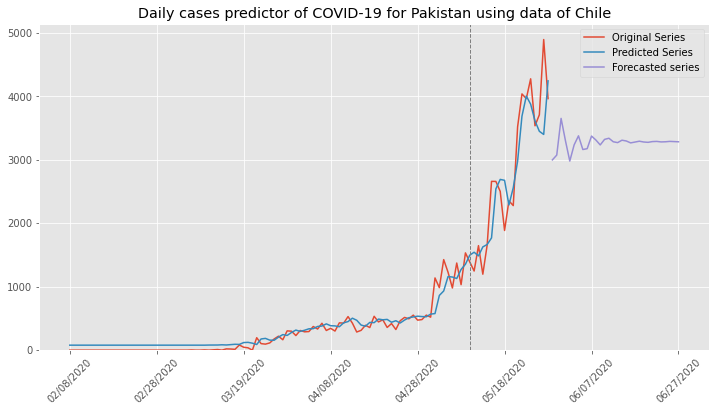

In [84]:
post_processing(evm_chi, "Chile")

# Predicting with the model of Belarus: 

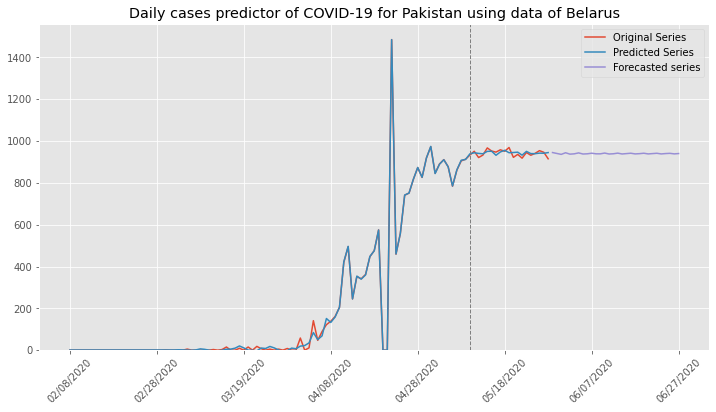

In [85]:
post_processing(evm_bel, "Belarus")

# Predicting with the model of Mexico: 

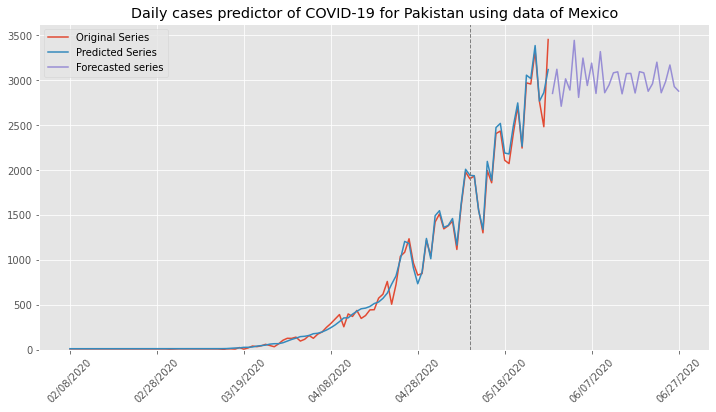

In [86]:
post_processing(evm_mex, "Mexico")

# Predicting with the model of Qatar: 

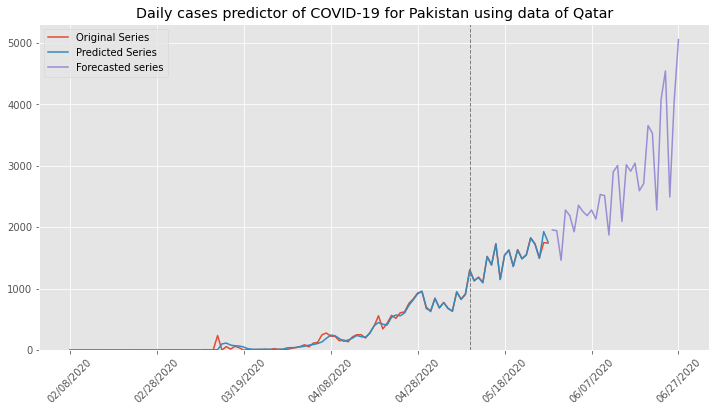

In [87]:
post_processing(evm_qat, "Qatar")

# Predicting with the model of Saudi Arabia: 

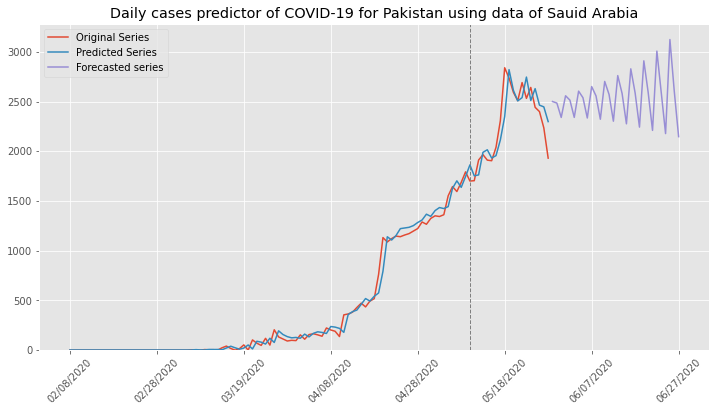

In [88]:
post_processing(evm_sau, "Sauid Arabia")

# Predicting with the model of Pakistan:


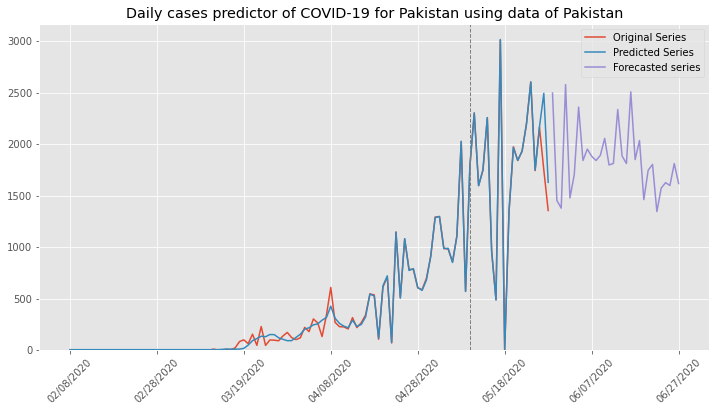

In [89]:
post_processing(evm_pak, "Pakistan")

In [0]:
from sklearn.metrics import r2_score

In [0]:
#Evaluating model performance through r2 Score

error = r2_score(evm_pak[0][-18:], evm_pak[1][-18:])

In [92]:
print("The confidence for predicting unknown values by our model is", error)

The confidence for predicting unknown values by our model is 0.9295674676511279


# Final Model
using complete data of pakistan to train and then predict for the future 27 days.

In [0]:
lstm_final = train_model_LSTM(pak_s_processed[0], pak_s_processed[1])
evm_final = evaluatemodel(pak_s_processed, lstm_final)
post_processing(evm_final, "Pakistan-all")